# Facial Emotion Recognition

### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import warnings
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, DepthwiseConv2D
from keras.layers import BatchNormalization, Activation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
warnings.filterwarnings('ignore')
from shutil import copyfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import imageio as iio
from sklearn.decomposition import PCA

### Getting Metadata

In [2]:
metadata = pd.read_csv('facial_expressions/data/legend.csv')
metadata

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral
...,...,...,...
13685,jhamski,SharmilaTagore_80.jpg,HAPPINESS
13686,jhamski,SharmilaTagore_81.jpg,HAPPINESS
13687,jhamski,SharmilaTagore_82.jpg,HAPPINESS
13688,jhamski,SharmilaTagore_83.jpg,HAPPINESS


In [3]:
all_images_path = 'facial_expressions/images'
image_content = os.listdir(all_images_path)
print(len(image_content))
image_content[:5]

13718


['Aaron_Eckhart_0001.jpg',
 'Aaron_Guiel_0001.jpg',
 'Aaron_Patterson_0001.jpg',
 'Aaron_Peirsol_0001.jpg',
 'Aaron_Peirsol_0002.jpg']

In [4]:
im = imread(os.path.join('facial_expressions/images',image_content[2323]))
im.shape

(350, 350)

In [5]:
sample_images = []
for i in range(64) :
    im = imread(os.path.join('facial_expressions/images',image_content[i]))
    sample_images.append(im)

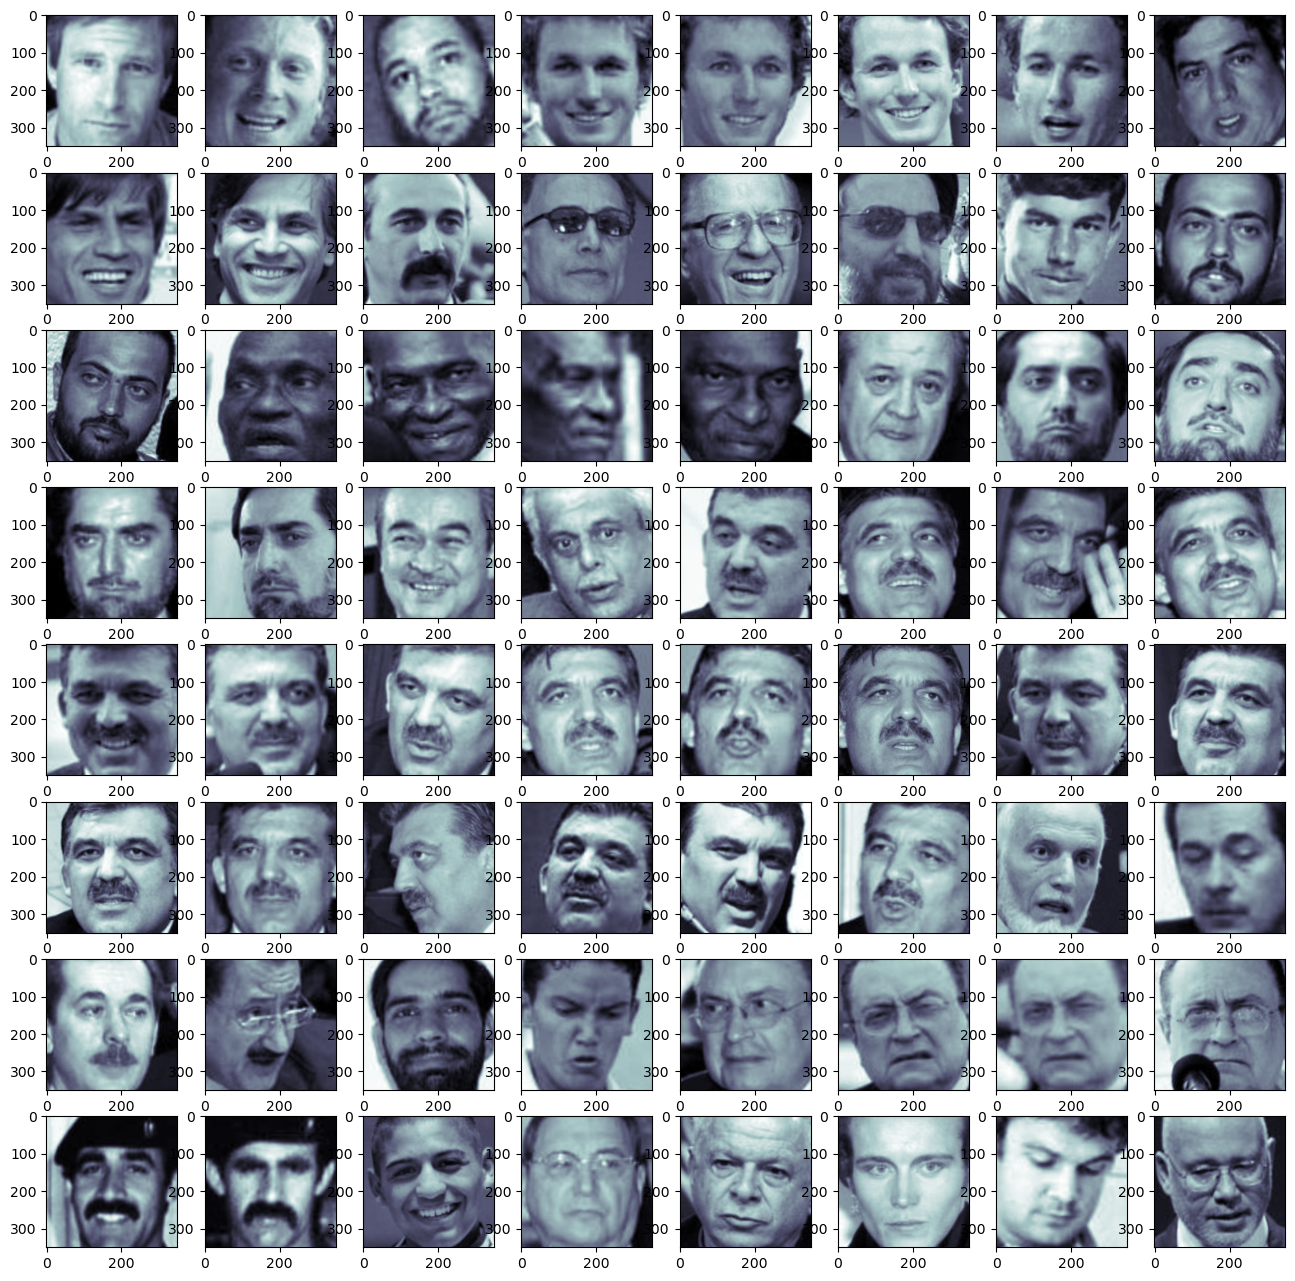

In [6]:
fig = plt.figure(figsize = (16, 16))
for i in range(64) :
    ax = fig.add_subplot(8, 8, i + 1)
    ax.imshow(sample_images[i], cmap = 'bone')
plt.show()

### Creating my own directories for storing data

In [7]:
os.makedirs("MasterData")
os.makedirs("MasterData/train_data")
os.makedirs("MasterData/test_data")

In [8]:
data = dict()
for row in metadata.values :
    file_name = row[1]
    class_name = row[2].lower()
    if not data.get(class_name) :
        data[class_name] = list()
    data[class_name].append(file_name)
list(data.keys())

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [9]:
### Traversing all unique classes.
### Creating New folders of each class in both train and test data.
for class_names in data :
    ### images of one class
    list_of_files = data[class_names]
    
    ### split data for both train and test set.
    train_size = int(len(list_of_files) * 0.8)
    train_set = list_of_files[: train_size]
    test_set = list_of_files[train_size: ]
    
    ## making class folder in train folder.
    os.makedirs(os.path.join("MasterData/train_data", class_names))
    
    ## appending all images of this class in this folder
    for train_images in train_set :
        source = os.path.join("facial_expressions/images", train_images)
        dest = os.path.join("MasterData/train_data", class_names, train_images)
        copyfile(source, dest)
    
    ## making class folder in test folder.
    os.makedirs(os.path.join("MasterData/test_data", class_names))
    
    ## appending all images of this class in this folder. 
    for test_images in test_set :
        source = os.path.join("facial_expressions/images", test_images)
        dest = os.path.join("MasterData/test_data", class_names, test_images)
        copyfile(source, dest)

### Create ImageDataGenerator class

#### This is Used for Data Augmentation. That is, creating more data from existing data.

In [10]:
### using this class directly for training and testing for image dataset
train_data_generator = ImageDataGenerator(featurewise_center=True,
                                featurewise_std_normalization=True,
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True)

In [11]:
train_generator = train_data_generator.flow_from_directory(
        "MasterData/train_data",
        target_size=(100, 100),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale"
)

Found 10941 images belonging to 8 classes.


In [12]:
test_data_generator = ImageDataGenerator(featurewise_center=True,
                                featurewise_std_normalization=True)

In [13]:
test_generator = test_data_generator.flow_from_directory(
        "MasterData/test_data",
        target_size=(100, 100),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale"
)

Found 2742 images belonging to 8 classes.


### Creating Model

In [14]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(32,(3,3), padding='same', input_shape=(100, 100, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(8, activation='softmax'))

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 33, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 33, 33, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 64)        5

In [15]:
model.fit_generator(train_generator, epochs = 6)

Epoch 1/6
86/86 [==============================] - 128s 1s/step - loss: 1.2392 - accuracy: 0.5074
Epoch 2/6
86/86 [==============================] - 84s 976ms/step - loss: 0.9809 - accuracy: 0.5928
Epoch 3/6
86/86 [==============================] - 84s 970ms/step - loss: 0.8978 - accuracy: 0.6440
Epoch 4/6
86/86 [==============================] - 84s 972ms/step - loss: 0.8398 - accuracy: 0.6744
Epoch 5/6
86/86 [==============================] - 84s 980ms/step - loss: 0.7897 - accuracy: 0.7038
Epoch 6/6
86/86 [==============================] - 84s 977ms/step - loss: 0.7498 - accuracy: 0.7207


### Predictions

In [16]:
y_pred = model.predict_generator(test_generator)

### Getting True Y values

In [18]:
test_content = os.listdir("MasterData/test_data")
y_true = list()
class_num = 0
for class_ in test_content :
    directory = os.path.join("MasterData/test_data", class_)
    content_ = os.listdir(directory)
    for i in content_ :
        y_true.append(class_num)
    class_num += 1

In [21]:
y_pred_change = list()
for y in y_pred :
    y_pred_change.append(np.argmax(y))